In [1]:
pip install lenskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numba==0.51

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U llvmlite==0.34

Requirement already up-to-date: llvmlite==0.34 in /home/oumy/Or/lib/python3.7/site-packages (0.34.0)
Note: you may need to restart the kernel to use updated packages.


In [4]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf #module provides support for preparing data sets.
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import pandas as pd

In [13]:
ml100k = ML100K('ml-25m')
ratings = pd.read_csv('ratings.csv')

In [14]:
ratings

,user,item,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
1048570,7045,4447,3.5,1164258032
1048571,7045,4720,4.0,1164257756
1048572,7045,4857,4.0,1164242753
1048573,7045,4886,5.0,1168033506


In [15]:
ratings.head()

,user,item,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [16]:
#A timestamp is a sequence of characters or encoded information identifying when a certain event occurred.
from datetime import datetime

print("DATETIME",datetime.fromtimestamp(ratings['timestamp'][0]))

DATETIME 2006-05-17 15:34:04


In [17]:
algo_ii = knn.ItemItem(20) # 20 : the maximum number of neighbors for scoring each item
algo_als = als.BiasedMF(40) # the number of features to train

In [166]:
#function to generate recommendations from one algorithm over a single partition of the data set.
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 10) # nrecs = 500
    recs['Algorithm'] = aname
    return recs

In [19]:
ratings.rating

0          5.0
1          3.5
2          5.0
3          5.0
4          3.5
          ... 
1048570    3.5
1048571    4.0
1048572    4.0
1048573    5.0
1048574    4.0
Name: rating, Length: 1048575, dtype: float64

In [167]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    #SampleFrac : Randomly select a fraction of test rows per item(20%)

    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

In [168]:
all_recs = pd.concat(all_recs, ignore_index= False)
all_recs

,item,score,user,rank,Algorithm
0,33264,6.505742,15,1,ItemItem
1,173351,6.356891,15,2,ItemItem
2,7488,6.150401,15,3,ItemItem
3,60654,6.003885,15,4,ItemItem
4,173355,6.002370,15,5,ItemItem
...,...,...,...,...,...
14085,7396,5.116561,7044,6,ALS
14086,112733,5.080897,7044,7,ALS
14087,7786,5.024371,7044,8,ALS
14088,151693,5.018038,7044,9,ALS


In [169]:
test_data = pd.concat(test_data, ignore_index=True)

In [170]:
rla = topn.RecListAnalysis() #RecListAnalysis will silently drop users who received no recommendations.
rla.add_metric(topn.ndcg) # topn : module contains metrics for evaluating top-N recommendation lists(precision, recall)
results = rla.compute(all_recs, test_data)
results

nrecs  ndcg
Algorithm user             
ItemItem  15       10   0.0
          17       10   0.0
          18       10   0.0
          24       10   0.0
          25       10   0.0
...               ...   ...
ALS       7031     10   0.0
          7034     10   0.0
          7037     10   0.0
          7043     10   0.0
          7044     10   0.0

[14090 rows x 2 columns]

In [172]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.012948
ItemItem    0.000085
Name: ndcg, dtype: float64

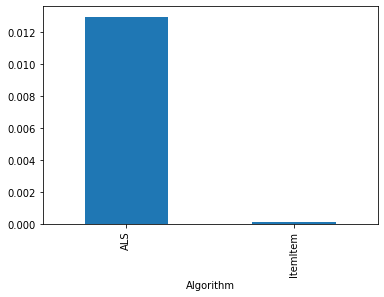

In [173]:
results.groupby('Algorithm').ndcg.mean().plot.bar()